In [224]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import sys
import argparse
from tqdm import tqdm
import pandas as pd
import gc
#sys.path.insert(0, '../lenstronomy/lenstronomy/')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
from lenstronomy.LensModel.lens_model import LensModel

In [225]:

from lenstronomy.SimulationAPI.sim_api import SimAPI
data = pd.read_csv('merged_agn_lc.csv')
data


def mag_to_flux(m, mz):
    return 10**((mz - m)/2.5)

mag_g = mag_to_flux(data['mag_g'],27.5)
mag_r = mag_to_flux(data['mag_r'],27.5)
mag_i = mag_to_flux(data['mag_i'],27.5)
mag_z = mag_to_flux(data['mag_z'],27.5)


print(mag_g, mag_r, mag_i, mag_z)
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.6
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)



# data specifics
sigma_bkg = 8.0  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.263  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 1.0  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)

0    393.786273
1    442.619576
2    360.827845
3    407.158901
4    473.461399
5    570.598417
6    576.653740
7    543.973838
8    527.577972
9    443.027013
Name: mag_g, dtype: float64 0    371.547676
1    343.162830
2    328.057100
3    350.622909
4    441.919350
5    460.670699
6    550.681478
7    488.829134
8    488.236290
9    542.256594
Name: mag_r, dtype: float64 0    348.086805
1    338.432875
2    405.765398
3    369.246685
4    377.774321
5    535.463995
6    565.961887
7    559.790302
8    541.592413
9    439.568722
Name: mag_i, dtype: float64 0    400.430120
1    521.020586
2    393.181973
3    360.479380
4    544.591158
5    504.141848
6    543.494748
7    564.181733
8    558.700556
9    491.755570
Name: mag_z, dtype: float64


In [226]:
def non_lens_agn_sim(numPix, bands):
    
    
    full_band_images = np.zeros((numPix, numPix, 4))
    center_x_1 = np.random.uniform(-0.03, 0.03)
    center_y_1 = np.random.uniform(-0.03, 0.03)
    center_x_2 = np.random.uniform(-4.3, 4.3)
    center_y_2 = np.random.uniform(-4.3, 4.3)
    center_x_list = [center_x_1, center_x_2]
    center_y_list = [center_y_1, center_y_2]
    
    light_model_list = ['SERSIC_ELLIPSE', 'SERSIC']
    lightModel = LightModel(light_model_list=light_model_list)
    
    e1, e2 = param_util.phi_q2_ellipticity(phi=0.3, q=0.6)
    kwargs_disk = {'amp': 100, 'n_sersic': 1, 'R_sersic': 0.7, 'e1': e1, 'e2': e2, 'center_x': center_x_1, 'center_y': center_y_1}
    kwargs_buldge = {'amp': 100, 'n_sersic': 4, 'R_sersic': 0.3, 'center_x': center_x_1, 'center_y': center_y_1}
    kwargs_host = [kwargs_disk, kwargs_buldge]
    
    
    for color_idx, band in enumerate(bands):
        #### lensing quantities

        fwhm_list = [1.12, 0.96, 0.88, 0.84] # PSF median from arXiv:1708.01533

        if color_idx ==0:
            mag_agn = mag_g
        elif color_idx ==1:
            mag_agn = mag_r
        elif color_idx ==2:
            mag_agn = mag_i
        elif color_idx ==3:
            mag_agn = mag_z

        #### psf condition for different bands

        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
        data_class = ImageData(**kwargs_data)
        kwargs_psf = {'psf_type': psf_type, 'fwhm':fwhm_list[color_idx], 'pixel_size': deltaPix, 'truncation': 3}
        psf_class = PSF(**kwargs_psf)


        #### pick two agn magnitude from the catalog
        agn_seed_1 = np.random.randint(0, 9)
        agn_seed_2 = np.random.randint(0, 9)
        point_source_list = ['UNLENSED']
        pointSource = PointSource(point_source_type_list=point_source_list)
        point_amp_list = [mag_agn[agn_seed_1], mag_agn[agn_seed_2]]
        kwargs_ps = [{'ra_image': center_x_list, 'dec_image': center_y_list, 'point_amp': point_amp_list}]
        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
        imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel,
                                    point_source_class=pointSource, kwargs_numerics=kwargs_numerics)

        


        # generate image
        image_sim = imageModel.image(kwargs_lens_light=kwargs_host, kwargs_ps=kwargs_ps)
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
        image_sim = image_sim + bkg + poisson

        data_class.update_data(image_sim)
        kwargs_data['image_data'] = image_sim


        full_band_images[:, :, color_idx] += image_sim
        ps_counts = 0 # non lens == 0
    return full_band_images, ps_counts

In [227]:
def non_lens_gal_sim(numPix, bands):
    
    
    full_band_images = np.zeros((numPix, numPix, 4))
    center_x_1 = np.random.uniform(-0.03, 0.03)
    center_y_1 = np.random.uniform(-0.03, 0.03)
#     center_x_2 = np.random.uniform(-4.3, 4.3)
#     center_y_2 = np.random.uniform(-4.3, 4.3)
#     center_x_list = [center_x_1, center_x_2]
#     center_y_list = [center_y_1, center_y_2]
    
    light_model_list = ['SERSIC_ELLIPSE', 'SERSIC']
    lightModel = LightModel(light_model_list=light_model_list)
    
    e1, e2 = param_util.phi_q2_ellipticity(phi=0.3, q=0.6)
    kwargs_disk = {'amp': 300, 'n_sersic': 1, 'R_sersic': 0.7, 'e1': e1, 'e2': e2, 'center_x': center_x_1, 'center_y': center_y_1}
    kwargs_buldge = {'amp': 100, 'n_sersic': 4, 'R_sersic': 0.3, 'center_x': center_x_1, 'center_y': center_y_1}
    kwargs_host = [kwargs_disk, kwargs_buldge]
    
    
    for color_idx, band in enumerate(bands):
        #### lensing quantities

        fwhm_list = [1.12, 0.96, 0.88, 0.84] # PSF median from arXiv:1708.01533

#         if color_idx ==0:
#             mag_agn = mag_g
#         elif color_idx ==1:
#             mag_agn = mag_r
#         elif color_idx ==2:
#             mag_agn = mag_i
#         elif color_idx ==3:
#             mag_agn = mag_z

        #### psf condition for different bands

        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
        data_class = ImageData(**kwargs_data)
        kwargs_psf = {'psf_type': psf_type, 'fwhm':fwhm_list[color_idx], 'pixel_size': deltaPix, 'truncation': 3}
        psf_class = PSF(**kwargs_psf)


        #### pick two agn magnitude from the catalog
#         agn_seed_1 = np.random.randint(0, 9)
#         agn_seed_2 = np.random.randint(0, 9)
#         point_source_list = ['UNLENSED']
#         pointSource = PointSource(point_source_type_list=point_source_list)
#         point_amp_list = [mag_agn[agn_seed_1], mag_agn[agn_seed_2]]
#         kwargs_ps = [{'ra_image': center_x_list, 'dec_image': center_y_list, 'point_amp': point_amp_list}]
        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
        imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel,
                                     kwargs_numerics=kwargs_numerics)

        


        # generate image
        image_sim = imageModel.image(kwargs_lens_light=kwargs_host)
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
        image_sim = image_sim + bkg + poisson

        data_class.update_data(image_sim)
        kwargs_data['image_data'] = image_sim


        full_band_images[:, :, color_idx] += image_sim
        ps_counts = -1 # non lens == 0
    return full_band_images, ps_counts

In [228]:
def lens_sim(numPix, bands):
    full_band_images = np.zeros((numPix, numPix, 4))
    mag_agn_seed = np.random.randint(0, 9)
     # generate the coordinate grid and image properties

    # lensing quantities

    ### mean of the lens parameters
    gamma_ext_mu, theta_E_mu, gamma_mu, lens_center_mu, lens_e_mu = 0.015, 1.4, 2.0, 0.0, 0.0

    gamma_ext_sigma, theta_E_sigma, gamma_sigma, lens_center_sigma, lens_e_sigma= 0.005, 0.4, 0.05, 0.2, 0.2

    gamma_ext = np.maximum(np.random.normal(gamma_ext_mu, gamma_ext_sigma), 0)
    psi_ext = np.random.uniform(0.0, 2* np.pi)
    theta_E = np.maximum(np.random.normal(loc=theta_E_mu, scale=theta_E_sigma), 0.1)
    gamma = np.maximum(np.random.normal(gamma_mu, gamma_sigma), 1.85)
    lens_center_x = np.random.normal(lens_center_mu, lens_center_sigma)
    lens_center_y = np.random.normal(lens_center_mu, lens_center_sigma)
    lens_e1 = np.minimum(np.random.normal(lens_e_mu, lens_e_sigma), 0.9)
    lens_e2 = np.minimum(np.random.normal(lens_e_mu, lens_e_sigma), 0.9)

    kwargs_shear = {'gamma_ext': gamma_ext, 'psi_ext': psi_ext}  # shear values to the source plane
    kwargs_spemd = {'theta_E': theta_E, 'gamma': gamma, 'center_x': lens_center_x, 'center_y': lens_center_y, 'e1': lens_e1, 'e2': lens_e2}  # parameters of the deflector lens model

    # the lens model is a supperposition of an elliptical lens model with external shear
    lens_model_list = ['SPEP', 'SHEAR_GAMMA_PSI']
    kwargs_lens = [kwargs_spemd, kwargs_shear]
    lens_model_class = LensModel(lens_model_list=lens_model_list)



    # choice of source type
    source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'
    source_position_mu = 0.0
    source_position_sigma = 0.1
    #sigma_source_position = 0.1
    source_x = np.random.normal(source_position_mu, source_position_sigma)
    source_y = np.random.normal(source_position_mu, source_position_sigma)


    # Sersic parameters in the initial simulation
    phi_G, q = 0.5, 0.8
    sersic_source_e1, sersic_source_e2 = param_util.phi_q2_ellipticity(phi_G, q)
    source_R_sersic_mu, source_R_sersic_sigma = 0.2, 0.1
    source_n_sersic_mu, source_n_sersic_sigma = 1.0, 0.1
    source_R_sersic = np.random.normal(source_R_sersic_mu, source_R_sersic_sigma)
    source_n_sersic = np.random.normal(source_n_sersic_mu, source_n_sersic_sigma)



    kwargs_sersic_source = {'amp': 1000, 'R_sersic': source_R_sersic, 'n_sersic': source_n_sersic, 'e1': sersic_source_e1, 'e2': sersic_source_e2, 'center_x': source_x, 'center_y': source_y}
    #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
    source_model_list = ['SERSIC_ELLIPSE']
    kwargs_source = [kwargs_sersic_source]
    source_model_class = LightModel(light_model_list=source_model_list)

    # lens light model
    phi_G, q = 0.9, 0.9
    lens_light_e1, lens_light_e2 = param_util.phi_q2_ellipticity(phi_G, q)
    lens_light_R_sersic_mu, lens_light_R_sersic_sigma = 0.3, 0.1
    lens_light_n_sersic_mu, lens_light_n_sersic_sigma = 1.0, 0.1
    lens_light_R_sersic = np.random.normal(lens_light_R_sersic_mu, lens_light_R_sersic_sigma)
    lens_light_n_sersic = np.random.normal(lens_light_n_sersic_mu, lens_light_n_sersic_sigma)
    kwargs_sersic_lens = {'amp': 1000, 'R_sersic': lens_light_R_sersic, 'n_sersic': lens_light_n_sersic , 'e1': lens_light_e1, 'e2': lens_light_e2, 'center_x': lens_center_x, 'center_y': lens_center_y}
    lens_light_model_list = ['SERSIC_ELLIPSE']
    kwargs_lens_light = [kwargs_sersic_lens]
    lens_light_model_class = LightModel(light_model_list=lens_light_model_list)





    for color_idx, band in enumerate(bands):
    # lensing quantities

        fwhm_list = [1.12, 0.96, 0.88, 0.84] # PSF median from arXiv:1708.01533

        if color_idx ==0:
            mag_agn = mag_g
        elif color_idx ==1:
            mag_agn = mag_r
        elif color_idx ==2:
            mag_agn = mag_i
        elif color_idx ==3:
            mag_agn = mag_z





        kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
        data_class = ImageData(**kwargs_data)
        # generate the psf variables
        #kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
        kwargs_psf = {'psf_type': psf_type, 'fwhm':fwhm_list[color_idx], 'pixel_size': deltaPix, 'truncation': 3}
        #kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
        psf_class = PSF(**kwargs_psf)


        lensEquationSolver = LensEquationSolver(lens_model_class)
        x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                              min_distance=deltaPix, search_window=numPix * deltaPix)
        mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)


        kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                                   'point_amp': np.abs(mag)*mag_agn[mag_agn_seed]}]  # quasar point source position in the source plane and intrinsic brightness
        point_source_list = ['LENSED_POSITION']
        point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

        kwargs_numerics = {'supersampling_factor': 1}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, point_source_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
        image_sim = image_sim + bkg + poisson
        #image_sim = add_noise(image_sim, kwargs_band =DES_survey_noise)#image_sim# + bkg + poisson

        data_class.update_data(image_sim)
        kwargs_data['image_data'] = image_sim


        kwargs_model = {'lens_model_list': lens_model_list,
                         'lens_light_model_list': lens_light_model_list,
                         'source_light_model_list': source_model_list,
                        'point_source_model_list': point_source_list
                         }
        full_band_images[:, :, color_idx] += image_sim
        
        ps_counts = x_image.shape[0]
    return full_band_images, ps_counts


In [229]:
test_img, ps_counts = lens_sim(numPix= 100, bands= ['g', 'r', 'i', 'z'])

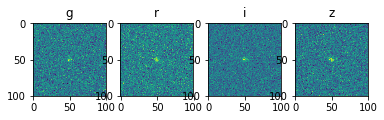

In [230]:
full_band_images, ps_counts = non_lens_gal_sim(numPix= 100, bands= ['g', 'r', 'i', 'z'])
plt.subplot(1, 4, 1)
plt.imshow(full_band_images[:, :, 0])
#plt.colorbar()
plt.title("g")
plt.subplot(1, 4, 2)
plt.imshow(full_band_images[:, :, 1])
plt.title("r")
plt.subplot(1, 4, 3)
plt.imshow(full_band_images[:, :, 2])
plt.title("i")
plt.subplot(1, 4, 4)
plt.imshow(full_band_images[:, :, 3])
plt.title("z")
plt.show()


simulation started
category: lens 4


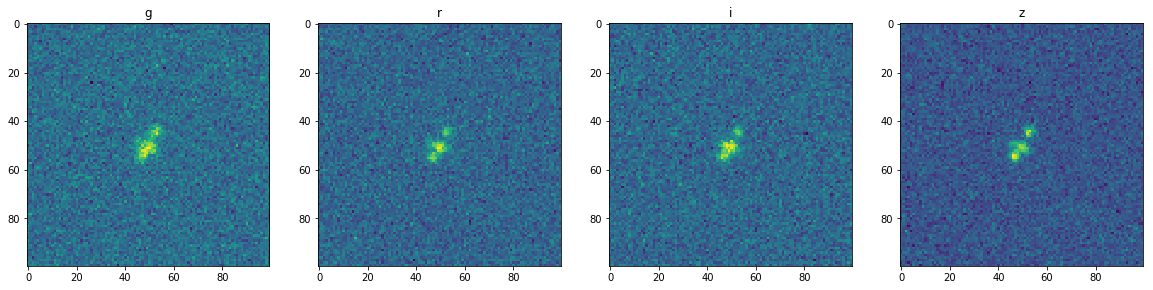

category: nonlens_agn 0


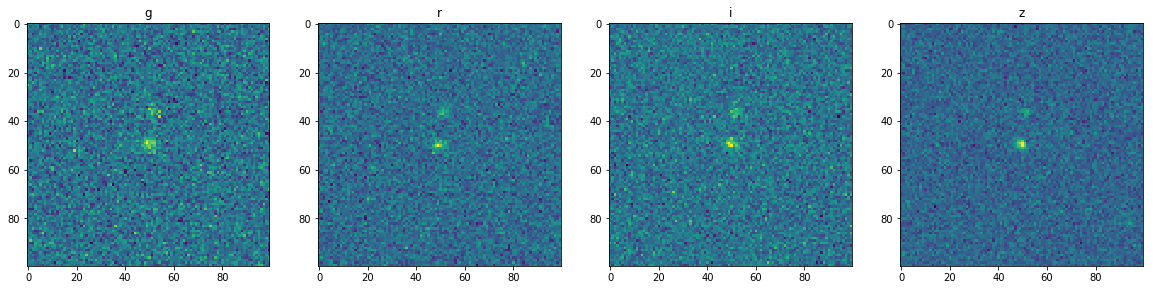

category: lens 4


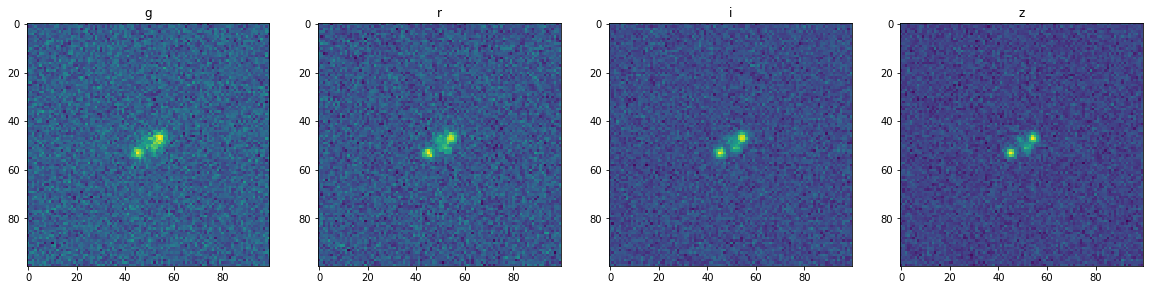

category: nonlens_gal -1


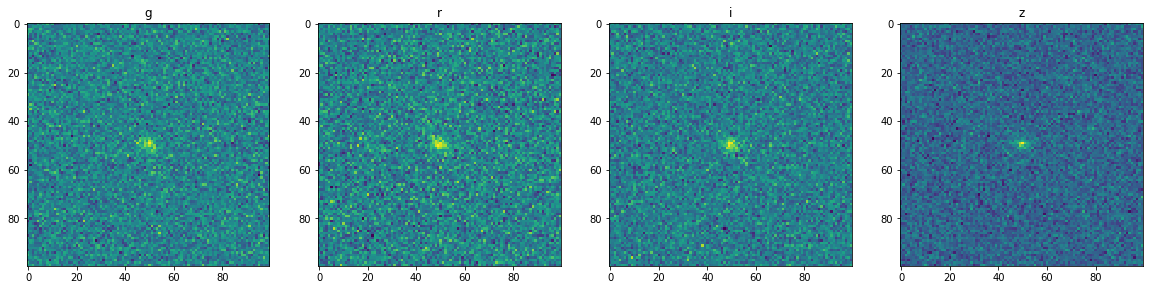

category: lens 4


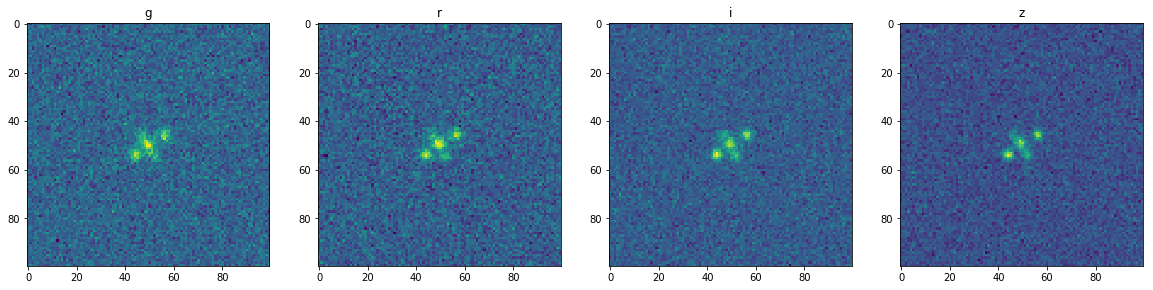

category: lens 4


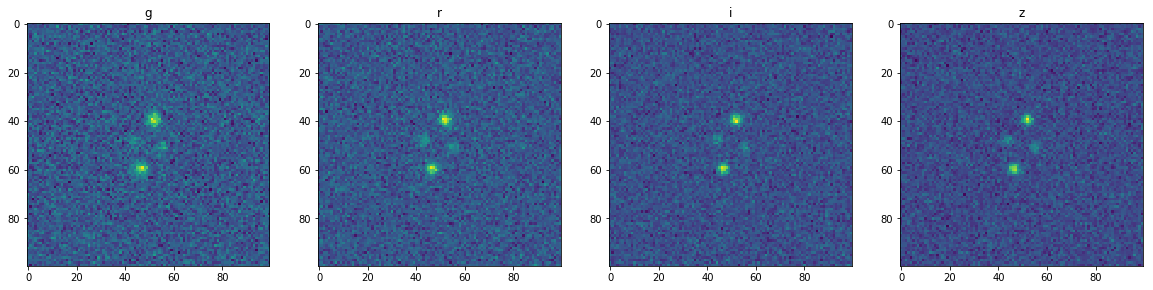

category: lens 4


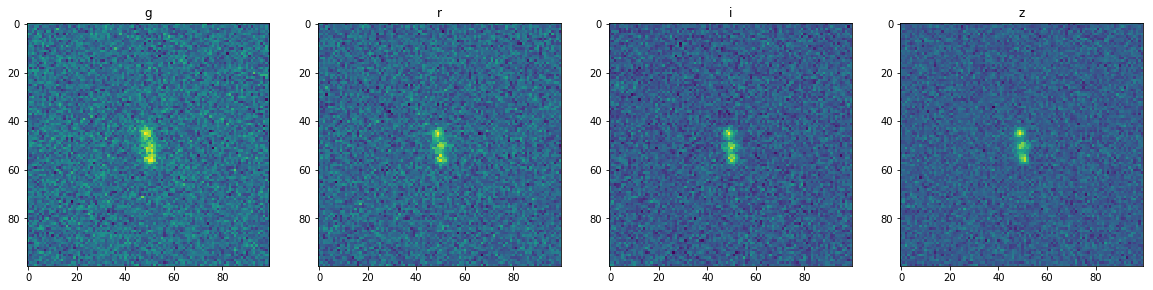

category: lens 4


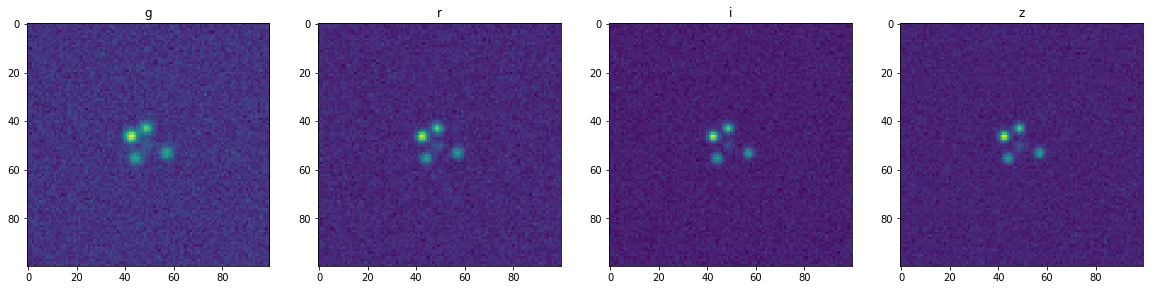

category: nonlens_gal -1


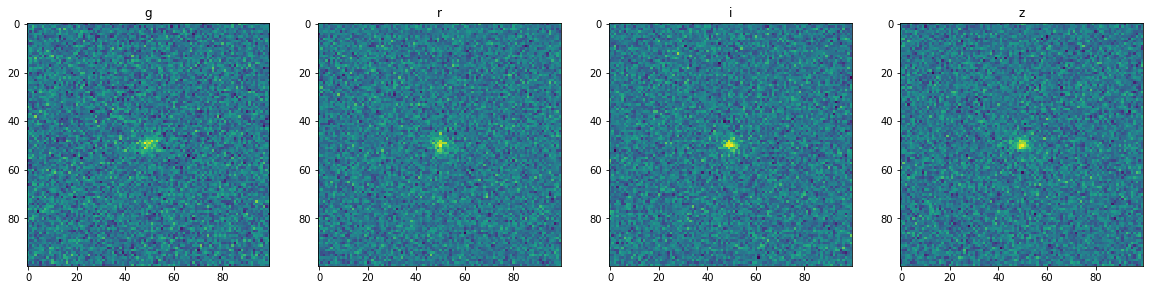

category: nonlens_gal -1


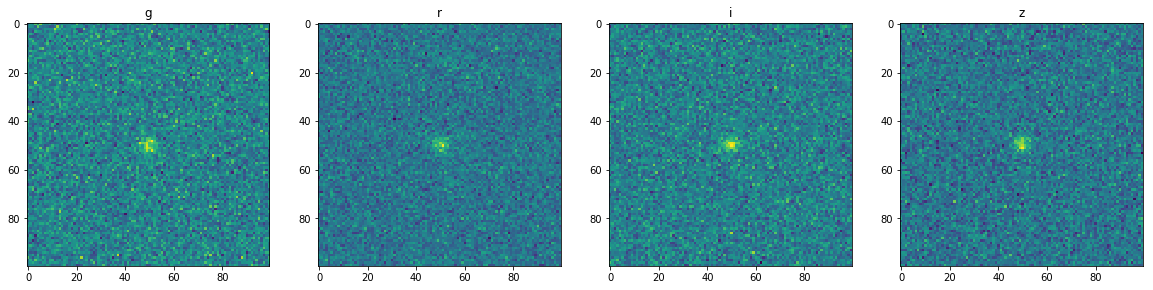

In [231]:
if __name__ == "__main__":
    print("simulation started")
    show_img = True
    IsTrain = True #False
    num_samples = 10
    root_folder = "./Full_sims_full_band/"
    if not os.path.exists(root_folder):
        os.mkdir(root_folder)

    if IsTrain:
        np.random.seed(12345)
        file_path = root_folder+"train/"
    else:
        np.random.seed(54321)
        file_path = root_folder+"test/"

    if not os.path.exists(file_path):
        os.mkdir(file_path)
        
    category = ['nonlens_gal','nonlens_agn', 'lens']
    for i in range(num_samples):
        sim_type = np.random.choice(category, p = [0.2,0.2, 0.6])
        if sim_type == 'nonlens_agn':
            full_band_images, ps_counts = non_lens_agn_sim(numPix= 100, bands= ['g', 'r', 'i', 'z'])
        elif sim_type == 'nonlens_gal':
            full_band_images, ps_counts = non_lens_gal_sim(numPix= 100, bands= ['g', 'r', 'i', 'z'])
        elif sim_type == 'lens':
            full_band_images, ps_counts = lens_sim(numPix= 100, bands= ['g', 'r', 'i', 'z'])
    
        df = pd.DataFrame([ps_counts], columns=['category'])
        df['name'] = 'image' +  "_" + "%07d" % (i+1)
        #df['category'] = ps_counts
        if i > 0:
            df_podcast = pd.concat([df_podcast, df], axis =0).reset_index(drop=True)
        else:
            df_podcast = df

        if show_img == True:
            print("category:", sim_type, ps_counts)
            plt.figure(figsize=(20,10))
            plt.subplot(1, 4, 1)
            plt.imshow(full_band_images[:, :, 0])
            #plt.colorbar()
            plt.title("g")
            plt.subplot(1, 4, 2)
            plt.imshow(full_band_images[:, :, 1])
            plt.title("r")
            plt.subplot(1, 4, 3)
            plt.imshow(full_band_images[:, :, 2])
            plt.title("i")
            plt.subplot(1, 4, 4)
            plt.imshow(full_band_images[:, :, 3])
            plt.title("z")
            plt.show()

        
        
    

In [232]:
df_podcast

,category,name
0,4,image_0000001
1,0,image_0000002
2,4,image_0000003
3,-1,image_0000004
4,4,image_0000005
5,4,image_0000006
6,4,image_0000007
7,4,image_0000008
8,-1,image_0000009
9,-1,image_0000010
